In [10]:
import pandas as pd
from pathlib import Path

# 1. CARICAMENTO DEL DATASET
file_path = r".\archive\All_Players_1992-2025.csv"
file_path:Path = Path(file_path)

# Leggiamo il CSV. 
df_original = pd.read_csv(file_path, encoding='utf-8')

print(f"Dimensioni originali del dataset: {df_original.shape}")
print("Esempio formato stagione:", df_original['Season'].unique()[:5])

# Applichiamo il filtro: Vogliamo che l'anno di inizio sia >= 2018
# Questo includerà 2018-2019, 2019-2020, ecc.
df = df_original[df_original['Season'] >= "2017-2018"].copy()

# 3. VERIFICA
print("-" * 30)
print(f"Dimensioni dopo il filtro: {df.shape}")
print("Stagioni rimaste:", sorted(df['Season'].unique()))

# Visualizziamo le prime righe
df.head()

Dimensioni originali del dataset: (92170, 120)
Esempio formato stagione: ['1992-1993' '1993-1994' '1999-2000' '2000-2001' '1994-1995']
------------------------------
Dimensioni dopo il filtro: (27040, 120)
Stagioni rimaste: ['2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022', '2022-2023', '2023-2024', '2024-2025']


,PlayerID,Player,Squad,League,Nation,Pos,Age,Born,Season,MP,...,The Best FIFA Mens Player,UEFA Best Player,UCL_MP,UCL_Gls,UCL_xG,UCL_Ast,UCL_xA,UCL_KP,UCL_GCA,UCL_SCA
5504,1681,Claudio Pizarro,Köln,Bundesliga,PER,"FW,MF",38.0,1978.0,2017-2018,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5513,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,FW,39.0,1978.0,2018-2019,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5514,1681,Claudio Pizarro,Werder Bremen,Bundesliga,PER,"FW,MF",40.0,1978.0,2019-2020,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6280,1842,Roman Weidenfeller,Dortmund,Bundesliga,GER,GK,36.0,1980.0,2017-2018,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6465,1877,Alexander Meier,Eint Frankfurt,Bundesliga,GER,FW,34.0,1983.0,2017-2018,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
import numpy as np

# Riempie i NaN con 0 per le stats, non dovrebbero esserci valori a NaN
df_clean = df.fillna(0).copy()

# creo un ID univoco per ogni giocatore in una stagione.
# in modo che MOFA lo consideri come un'entità separata
df_clean['SampleID'] = df_clean['Player'] + '_' + df_clean['Season']
df_clean = df_clean.set_index('SampleID')

# definisco nuove colonne calcolate
# attack
df_clean['Gls/90'] = df_clean['Gls'] / df_clean['90s'] # goal su 90 min
df_clean['npxG/90'] = df_clean['npxG'] / df_clean['90s'] # expected goal su 90 min
# passing
df_clean['Cmp/90'] = df_clean['Cmp'] / df_clean['90s'] # passaggi completati su 90 min
df_clean['KP/90'] = df_clean['KP'] / df_clean['90s'] # key passes su 90 min
df_clean['xA/90'] = df_clean['xA'] / df_clean['90s'] # expected assists su 90 min
df_clean['TB/90'] = df_clean['TB'] / df_clean['90s'] # passaggi filtranti su 90 min
# defence
df_clean['Tkl/90'] = df_clean['Tkl'] / df_clean['90s'] # contrasti su 90 min
df_clean['Int/90'] = df_clean['Int'] / df_clean['90s'] # intercettazioni su 90 min
df_clean['Blocks/90'] = df_clean['Blocks'] / df_clean['90s'] # respinte su 90 min
df_clean['Clr/90'] = df_clean['Clr'] / df_clean['90s'] # rinvii su 90 min
# duels
df_clean['TotalDuels/90'] = (df_clean['Won'] + df_clean['Lost']) / df_clean['90s'] # duelli totali su 90 min

# rimuove gli infiniti che fanno crashare MOFA ai passi successivi
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.fillna(0, inplace=True)

# definisco le viste
views_definition = {
    'Attack': ['Sh/90', 'Gls/90', 'npxG/90'],
    'Passing': ['Cmp/90', 'KP/90', 'xA/90', 'TB/90'],
    'Defence': ['Tkl/90', 'Int/90', 'Blocks/90', 'Clr/90'],
    'Duels': ['TotalDuels/90', 'Won%'],
}

data_for_mofa = [] # Lista di matrici
view_names = []    # Lista dei nomi delle viste

print("Creazione matrici per MOFA...")
for view, cols in views_definition.items():
    # Selezioniamo solo le colonne che esistono davvero nel dataset
    valid_cols = [c for c in cols if c in df_clean.columns]
    
    if valid_cols:
        # Estraiamo la matrice di dati
        matrix = df_clean[valid_cols].values
        
        # MOFA vuole le dimensioni (N_samples, N_features)
        print(f"Vista '{view}': {matrix.shape[1]} features trovate.")
        
        data_for_mofa.append([matrix])
        view_names.append(view)
    else:
        print(f"ATTENZIONE: Nessuna colonna trovata per la vista '{view}'. Controlla i nomi.")

Creazione matrici per MOFA...
Vista 'Attack': 3 features trovate.
Vista 'Passing': 4 features trovate.
Vista 'Defence': 4 features trovate.
Vista 'Duels': 2 features trovate.


In [12]:
from mofapy2.run.entry_point import entry_point

# --- B. ESECUZIONE DI MOFA ---

if len(data_for_mofa) > 0:
    print("\n--- Inizio Training MOFA ---")
    
    # 1. Inizializzazione
    ent = entry_point()
    
    # 2. Data Options
    # Passiamo la lista di matrici. 
    # Importante: scale_views=True aiuta a bilanciare se l'Attacco ha numeri piccoli e il Possesso numeri grandi.
    ent.set_data_matrix(data=data_for_mofa, views_names=view_names)
    ent.set_data_options(scale_views=True, center_groups=True)
    
    # 3. Model Options
    # num_factors: Quanti "super-valori" vuoi trovare? 10 è un buon punto di partenza.
    ent.set_model_options(factors=10, spikeslab_weights=True, ard_factors=True)
    
    # 4. Training Options
    # max_iter: numero di cicli di apprendimento
    ent.set_train_options(iter=1000, convergence_mode='fast', verbose=False)
    ent.build()
    
    # 5. RUN
    ent.run()
    
    print("Training completato con successo!")
    
    # Salviamo il modello in un oggetto per usarlo dopo
    model = ent.model
else:
    print("Errore: Non ci sono dati validi per avviare il modello.")


--- Inizio Training MOFA ---

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group2, ..., sampleN_groupG

Successfully loaded view='Attack

In [ ]:
# VISUALIZZA FATTORI LATENTI

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Estraiamo il dizionario dei Fattori Latenti (Z)
z_dict = ent.model.getExpectations()["Z"]

# --- DEBUG: Stampiamo le chiavi per vedere come MOFA ha chiamato il gruppo ---
print(f"Nomi dei gruppi trovati nel modello: {list(z_dict.keys())}")

# --- SOLUZIONE ROBUSTA ---
# Invece di scrivere [0], prendiamo dinamicamente la prima chiave disponibile
group_name = list(z_dict.keys())[0] 
Z_matrix = z_dict[group_name]

print(f"Matrice Z estratta per il gruppo: '{group_name}'")
print(f"Dimensioni matrice: {Z_matrix.shape}")

# 2. Creiamo un DataFrame pandas
# Usiamo l'indice di df_clean per riassociare i nomi (SampleID) ai punti
factor_columns = [f"Factor{i+1}" for i in range(Z_matrix.shape[1])]

df_factors = pd.DataFrame(
    Z_matrix, 
    index=df_clean.index, 
    columns=factor_columns
)

df_factors.head()

Nomi dei gruppi trovati nel modello: ['E', 'E2']
Matrice Z estratta per il gruppo: 'E'
Dimensioni matrice: (27040, 10)


,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10
SampleID,,,,,,,,,,
Claudio Pizarro_2017-2018,0.468280,0.533333,5.294909,0.496117,-0.315200,0.036942,2.055755e-20,-2.862694e-09,-8.768474e-16,-4.668658e-24
Claudio Pizarro_2018-2019,1.824903,-1.604821,9.258094,1.196259,0.696986,-0.009764,7.379065e-20,-1.010845e-08,-5.711513e-15,-2.157518e-23
Claudio Pizarro_2019-2020,1.078274,-0.229772,5.148859,0.066722,-1.949358,-0.111076,1.352646e-19,-1.693662e-08,-1.257106e-14,-4.840188e-23
Roman Weidenfeller_2017-2018,-4.687211,0.613982,-3.130322,-0.968761,0.717573,-0.020274,3.297767e-20,-7.487267e-10,-6.245456e-15,-3.753887e-23
Alexander Meier_2017-2018,3.795620,-11.260783,7.427950,-0.696297,0.326093,0.131655,-2.639051e-19,2.069278e-08,3.039869e-14,1.685337e-22


Shape dei Pesi: (13, 11)


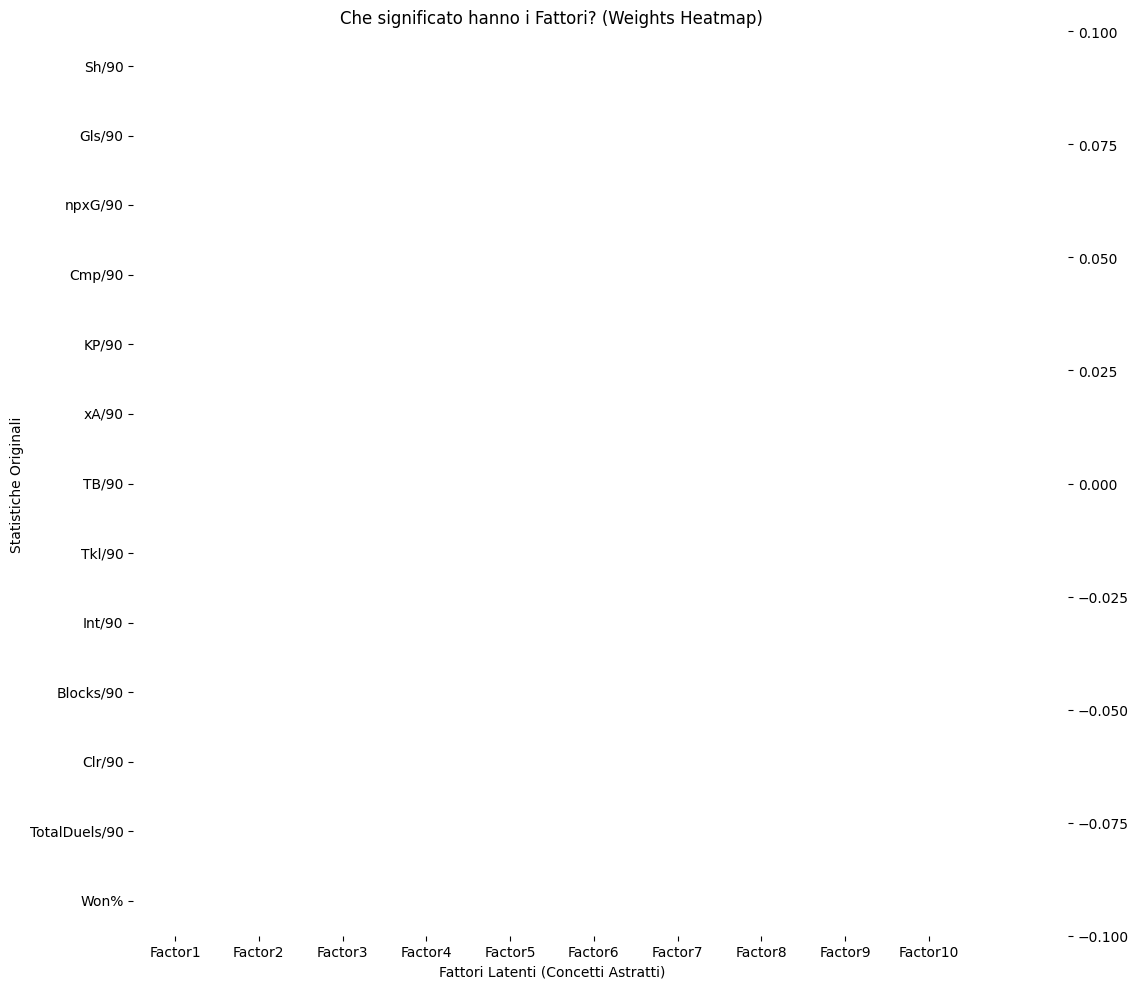

In [21]:
# ESTRAZIONE DEI PESI

# 1. Recuperiamo i pesi (W) dal modello
weights_dict = ent.model.getExpectations()["W"]

# 2. Uniamo tutti i pesi in un unico DataFrame
weights_list = []
feature_names_list = []

# Iteriamo su ogni vista (Attack, Passing, etc.)
for i, view in enumerate(view_names):
    # Estraiamo la matrice dei pesi per questa vista
    # W_view ha dimensione (N_features_della_vista x N_fattori)
    W_view = weights_dict[i]
    
    # Cerchiamo i nomi delle colonne (features) originali per questa vista
    # (Dobbiamo ritrovarli dalla definizione originale o dall'ordine in cui li abbiamo passati)
    cols = views_definition[view] 
    # Filtriamo solo quelli che erano validi nel df_clean
    valid_cols = [c for c in cols if c in df_clean.columns]
    
    # Creiamo un mini-dataframe per questa vista
    df_w_view = pd.DataFrame(W_view, index=valid_cols, columns=factor_columns)
    
    # Aggiungiamo una colonna per ricordarci da che vista arrivano
    df_w_view['View'] = view
    
    weights_list.append(df_w_view)

# Concateniamo tutto: Ora abbiamo una riga per ogni statistica (Goal, Assist, Tackle...)
df_weights = pd.concat(weights_list)

print("Shape dei Pesi:", df_weights.shape)
df_weights.head()


# HEATMAP DEI PESI

plt.figure(figsize=(12, 10))

# 1. Togliamo la colonna 'View' (che è testo)
data_to_plot = df_weights.drop('View', axis=1)
# 2. --- FIX CRITICO: Forziamo la conversione a numeri decimali (float) ---
# Se c'erano valori interpretati come oggetti, questo li fa diventare numeri
data_to_plot = data_to_plot.astype(float)

# 3. Disegniamo la heatmap
sns.heatmap(
    data_to_plot, 
    cmap="vlag",   # Blu = negativo, Rosso = positivo
    center=0, 
    annot=False,   # Metti True se vuoi vedere i numeri precisi
    yticklabels=True
)

plt.title("Che significato hanno i Fattori? (Weights Heatmap)")
plt.xlabel("Fattori Latenti (Concetti Astratti)")
plt.ylabel("Statistiche Originali")
# Aggiusta i margini per non tagliare le etichette
plt.tight_layout()
plt.show()